In [1]:
import torch
from torch.utils.data import Dataset, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os.path
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# one_hot = torch.nn.functional.one_hot(target)

'''
# Get training device
if torch.cuda.is_available():
  print("GPU is available, using device 1")
  dev = "cuda:0" 
else:  
  print("GPU is not available, using CPU")
  dev = "cpu"  
device = torch.device(dev)
'''
device = torch.device('mps')

In [3]:
# Data class for taxi
class taxiData(Dataset):
  def __init__(self, csv_file):
    if os.path.isfile('cached_dataframe.pkl'):
      df = pd.read_pickle('cached_dataframe.pkl')
    else:
      df = pd.read_csv(csv_file)
      df.to_pickle('cached_dataframe.pkl')
    all_xy = df.to_numpy()
    
#    tmp_x = all_xy[:,0:7]
 
    call_type_data =    np.array(all_xy[:,0:66]     )
    taxi_id_data =      np.array(all_xy[:,66:516]   )
    month_data =        np.array(all_xy[:,516:528]  )
    weekday_data =      np.array(all_xy[:,528:535]  )
    time_data =         np.array(all_xy[:,535:536]  , dtype=np.float32)
    daytype_data =      np.array(all_xy[:,536:539]  )
    triptime_data =     np.array(all_xy[:,539]      , dtype=np.float32)

    #print(np.concatenate([time_data, daytype_data], axis=1))

    all_data = torch.tensor(all_xy[:,0:539], dtype=torch.float32)
    tmp_x = all_data

#    tmp_x = torch.unsqueeze(all_data, 1)
#    tmp_x = tmp_x.repeat(1, 2, 1)
#    tmp_x = all_data.repeat(1, 2)

    tmp_x = tmp_x.to(device)
    print(tmp_x.shape)

#    print(tmp_x)
#    print(tmp_x.shape)
#    print(tmp_x[0].shape)
#    print(tmp_x.shape)

    #tmp_x = all_xy[:,0:539]
    #tmp_y = all_xy[:,539]
#    print(tmp_x)
#    print(tmp_y)

    tmp_y = triptime_data
    self.x = tmp_x.to(device)

#    self.x = torch.tensor(tmp_x, dtype=torch.float32).to(device)
#    self.x = torch.tensor(tmp_x).to(device)

    print(self.x)
    self.y = torch.tensor(tmp_y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

taxi_train = taxiData('outfile.csv')
print(taxi_train)

torch.Size([1710660, 539])
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='mps:0')


In [4]:
batch_size = 600
train_loader = torch.utils.data.DataLoader(taxi_train, batch_size=batch_size, shuffle=True)

In [5]:
model = nn.Sequential(
    nn.Linear(539, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 1)
)

In [6]:
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=539, out_features=2156, bias=True)
  (1): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=2156, out_features=2156, bias=True)
  (4): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=2156, out_features=2156, bias=True)
  (7): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=2156, out_features=2156, bias=True)
  (10): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=2156, out_features=1, bias=True)
)


In [7]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00000001)

In [8]:
losses = []

epochs = 150
for epoch in tqdm(range(epochs)):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
#    print(i, data)
    params, trip_time = data[0].to(device), data[1].to(device)
    trip_time = trip_time.float()
#    params, trip_time = params.float(), trip_time.float()
    trip_time = trip_time.reshape((trip_time.shape[0], 1))
    '''
    print(params)
    print(params.shape)
    print(trip_time)
    print(trip_time.shape)
    '''

    optimizer.zero_grad()
    params = params.to(torch.float)
    outputs = model(params)
#    print(outputs)
    loss = loss_fn(outputs, trip_time)
    running_loss += loss.item()
    loss.backward()
    model.float()
    optimizer.step()

#    if i % 2000 == 1999:    # print every 2000 mini-batches
#       print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
  print(f'[{epoch + 1}] loss: {running_loss / i:.13f}')
  losses.append(running_loss)

PATH = './jun6_10pm.pth'
torch.save(model.state_dict(), PATH)

print("======= DONE =======")

  1%|          | 1/150 [01:31<3:47:11, 91.49s/it]

[1] loss: 993786.1882234304212


  1%|▏         | 2/150 [03:03<3:46:27, 91.80s/it]

[2] loss: 973662.2417134338757


  2%|▏         | 3/150 [04:35<3:44:44, 91.73s/it]

[3] loss: 953524.5750175376888


  3%|▎         | 4/150 [06:06<3:43:14, 91.74s/it]

[4] loss: 933630.0048338302877


  3%|▎         | 5/150 [07:38<3:41:40, 91.73s/it]

[5] loss: 913464.8497018589405


  4%|▍         | 6/150 [09:10<3:40:09, 91.73s/it]

[6] loss: 892744.8087513153441


  5%|▍         | 7/150 [10:42<3:38:36, 91.72s/it]

[7] loss: 871641.7221698526992


  5%|▌         | 8/150 [12:13<3:36:34, 91.51s/it]

[8] loss: 849672.6888262890279


  6%|▌         | 9/150 [13:42<3:33:34, 90.88s/it]

[9] loss: 826202.4119278322905


  7%|▋         | 10/150 [15:12<3:31:03, 90.45s/it]

[10] loss: 802439.0337052788818


  7%|▋         | 11/150 [16:41<3:28:50, 90.15s/it]

[11] loss: 780415.2715384953190


  8%|▊         | 12/150 [18:10<3:26:47, 89.91s/it]

[12] loss: 759656.8794392318232


  9%|▊         | 13/150 [19:40<3:24:56, 89.75s/it]

[13] loss: 739462.6529178358614


  9%|▉         | 14/150 [21:09<3:23:19, 89.70s/it]

[14] loss: 719594.4481980006676


 10%|█         | 15/150 [22:38<3:21:16, 89.46s/it]

[15] loss: 699937.4337732375134


 11%|█         | 16/150 [24:08<3:19:50, 89.48s/it]

[16] loss: 680143.7099592247978


 11%|█▏        | 17/150 [25:38<3:18:57, 89.76s/it]

[17] loss: 660460.9928862679517


 12%|█▏        | 18/150 [27:09<3:17:55, 89.97s/it]

[18] loss: 640999.6632760434877


 13%|█▎        | 19/150 [28:39<3:16:44, 90.11s/it]

[19] loss: 622329.0797417572467


 13%|█▎        | 20/150 [30:10<3:15:33, 90.26s/it]

[20] loss: 604629.9294764994411


 14%|█▍        | 21/150 [31:40<3:14:23, 90.41s/it]

[21] loss: 588028.4360641003586


 15%|█▍        | 22/150 [33:11<3:13:08, 90.54s/it]

[22] loss: 572547.5191380217439


 15%|█▌        | 23/150 [34:42<3:11:48, 90.62s/it]

[23] loss: 558019.4920039020944


 16%|█▌        | 24/150 [36:13<3:10:19, 90.63s/it]

[24] loss: 544491.2864839091199


 17%|█▋        | 25/150 [37:44<3:08:54, 90.68s/it]

[25] loss: 531774.0152852069587


 17%|█▋        | 26/150 [39:14<3:07:27, 90.71s/it]

[26] loss: 519940.1100107418606


 18%|█▊        | 27/150 [40:45<3:06:01, 90.74s/it]

[27] loss: 509000.4413363732165


 19%|█▊        | 28/150 [42:16<3:04:17, 90.64s/it]

[28] loss: 498541.0019620308885


 19%|█▉        | 29/150 [43:46<3:02:40, 90.58s/it]

[29] loss: 489163.9113962206175


 20%|██        | 30/150 [45:16<3:01:04, 90.54s/it]

[30] loss: 480396.0044556734501


 21%|██        | 31/150 [46:47<2:59:30, 90.50s/it]

[31] loss: 471972.1673097158782


 21%|██▏       | 32/150 [48:18<2:58:18, 90.67s/it]

[32] loss: 464497.1382628902211


 22%|██▏       | 33/150 [49:50<2:57:19, 90.94s/it]

[33] loss: 457312.0649169151438


 23%|██▎       | 34/150 [51:21<2:56:07, 91.10s/it]

[34] loss: 450664.8514501490863


 23%|██▎       | 35/150 [52:53<2:54:53, 91.25s/it]

[35] loss: 444474.3978702648310


 24%|██▍       | 36/150 [54:24<2:53:36, 91.37s/it]

[36] loss: 438846.4353899947600


 25%|██▍       | 37/150 [55:56<2:52:13, 91.45s/it]

[37] loss: 433560.6862504384480


 25%|██▌       | 38/150 [57:27<2:50:43, 91.46s/it]

[38] loss: 428555.3979990573716


 26%|██▌       | 39/150 [58:58<2:48:58, 91.34s/it]

[39] loss: 424288.3536314012599


 27%|██▋       | 40/150 [1:00:29<2:47:06, 91.15s/it]

[40] loss: 420203.5955750175635


 27%|██▋       | 41/150 [1:02:00<2:45:22, 91.03s/it]

[41] loss: 416102.3567279024865


 28%|██▊       | 42/150 [1:03:31<2:43:42, 90.95s/it]

[42] loss: 412422.2036949754693


 29%|██▊       | 43/150 [1:05:01<2:41:51, 90.77s/it]

[43] loss: 409179.6238271659240


 29%|██▉       | 44/150 [1:06:32<2:40:21, 90.76s/it]

[44] loss: 405836.0739652753691


 30%|███       | 45/150 [1:08:03<2:38:50, 90.77s/it]

[45] loss: 402821.8242310811765


 31%|███       | 46/150 [1:09:33<2:37:19, 90.76s/it]

[46] loss: 400146.3637868291698


 31%|███▏      | 47/150 [1:11:04<2:35:46, 90.74s/it]

[47] loss: 397433.7251896264497


 32%|███▏      | 48/150 [1:12:35<2:34:13, 90.72s/it]

[48] loss: 394948.0968136180309


 33%|███▎      | 49/150 [1:14:05<2:32:21, 90.51s/it]

[49] loss: 392606.0607517099124


 33%|███▎      | 50/150 [1:15:34<2:30:14, 90.15s/it]

[50] loss: 390387.0546135128243


 34%|███▍      | 51/150 [1:17:04<2:28:41, 90.11s/it]

[51] loss: 388217.6982637671172


 35%|███▍      | 52/150 [1:18:34<2:27:20, 90.21s/it]

[52] loss: 385937.1225282795494


 35%|███▌      | 53/150 [1:20:05<2:25:57, 90.29s/it]

[53] loss: 383503.4074557172717


 36%|███▌      | 54/150 [1:21:35<2:24:32, 90.34s/it]

[54] loss: 381826.2740376183647


 37%|███▋      | 55/150 [1:23:06<2:23:05, 90.38s/it]

[55] loss: 380360.9618500087527


 37%|███▋      | 56/150 [1:24:36<2:21:33, 90.36s/it]

[56] loss: 378625.6012254472007


 38%|███▊      | 57/150 [1:26:07<2:20:12, 90.46s/it]

[57] loss: 376633.2837765257573


 39%|███▊      | 58/150 [1:27:38<2:18:50, 90.55s/it]

[58] loss: 375244.2985136794159


 39%|███▉      | 59/150 [1:29:08<2:17:26, 90.62s/it]

[59] loss: 373367.1213116011932


 40%|████      | 60/150 [1:30:39<2:15:59, 90.66s/it]

[60] loss: 371776.1381423184648


 41%|████      | 61/150 [1:32:10<2:14:32, 90.70s/it]

[61] loss: 370191.9998958698707


 41%|████▏     | 62/150 [1:33:41<2:13:03, 90.72s/it]

[62] loss: 373688.6315821203170


 42%|████▏     | 63/150 [1:35:11<2:11:34, 90.74s/it]

[63] loss: 370910.0781250000000


 43%|████▎     | 64/150 [1:36:42<2:10:03, 90.74s/it]

[64] loss: 366319.6345224263496


 43%|████▎     | 65/150 [1:38:13<2:08:34, 90.76s/it]

[65] loss: 364323.6806164503796


 44%|████▍     | 66/150 [1:39:44<2:07:05, 90.78s/it]

[66] loss: 363125.1013131357613


 45%|████▍     | 67/150 [1:41:15<2:05:35, 90.78s/it]

[67] loss: 361526.3862131708302


 45%|████▌     | 68/150 [1:42:45<2:04:05, 90.80s/it]

[68] loss: 359946.3736106848228


 46%|████▌     | 69/150 [1:44:16<2:02:34, 90.79s/it]

[69] loss: 358598.8021938574384


 47%|████▋     | 70/150 [1:45:47<2:01:03, 90.79s/it]

[70] loss: 357264.3707799894619


 47%|████▋     | 71/150 [1:47:18<1:59:31, 90.78s/it]

[71] loss: 356399.2245319624781


 48%|████▊     | 72/150 [1:48:49<1:57:59, 90.76s/it]

[72] loss: 354618.8843059453066


 49%|████▊     | 73/150 [1:50:19<1:56:21, 90.67s/it]

[73] loss: 353465.8731695019524


 49%|████▉     | 74/150 [1:51:50<1:54:47, 90.63s/it]

[74] loss: 351750.1323987197247


 50%|█████     | 75/150 [1:53:20<1:53:12, 90.57s/it]

[75] loss: 351229.9515959312557


 51%|█████     | 76/150 [1:54:50<1:51:38, 90.52s/it]

[76] loss: 349307.0412711548852


 51%|█████▏    | 77/150 [1:56:21<1:50:04, 90.47s/it]

[77] loss: 348784.5592171606258


 52%|█████▏    | 78/150 [1:57:51<1:48:30, 90.43s/it]

[78] loss: 347662.1796984610846


 53%|█████▎    | 79/150 [1:59:21<1:46:59, 90.42s/it]

[79] loss: 345862.8843223868753


 53%|█████▎    | 80/150 [2:00:52<1:45:28, 90.41s/it]

[80] loss: 344968.1992995878682


 54%|█████▍    | 81/150 [2:02:22<1:43:57, 90.39s/it]

[81] loss: 343641.3088225622778


 55%|█████▍    | 82/150 [2:03:52<1:42:25, 90.37s/it]

[82] loss: 341687.7589825938339


 55%|█████▌    | 83/150 [2:05:23<1:40:54, 90.36s/it]

[83] loss: 341193.6503858295619


 56%|█████▌    | 84/150 [2:06:53<1:39:22, 90.35s/it]

[84] loss: 339952.2743664503796


 57%|█████▋    | 85/150 [2:08:23<1:37:50, 90.32s/it]

[85] loss: 338982.9332334049395


 57%|█████▋    | 86/150 [2:09:54<1:36:21, 90.33s/it]

[86] loss: 337605.3524092423613


 58%|█████▊    | 87/150 [2:11:24<1:34:50, 90.33s/it]

[87] loss: 336932.1167298755026


 59%|█████▊    | 88/150 [2:12:54<1:33:20, 90.33s/it]

[88] loss: 335597.4287886925740


 59%|█████▉    | 89/150 [2:14:25<1:31:49, 90.32s/it]

[89] loss: 334628.0815229305299


 60%|██████    | 90/150 [2:15:54<1:30:01, 90.02s/it]

[90] loss: 333693.9521768677514


 61%|██████    | 91/150 [2:17:23<1:28:17, 89.79s/it]

[91] loss: 333804.8539437916479


 61%|██████▏   | 92/150 [2:18:53<1:26:40, 89.67s/it]

[92] loss: 331937.1887111978140


 62%|██████▏   | 93/150 [2:20:22<1:25:05, 89.57s/it]

[93] loss: 331209.5204314275761


 63%|██████▎   | 94/150 [2:21:51<1:23:30, 89.48s/it]

[94] loss: 329552.6082213477930


 63%|██████▎   | 95/150 [2:23:21<1:21:58, 89.43s/it]

[95] loss: 328714.5648319668253


 64%|██████▍   | 96/150 [2:24:51<1:20:37, 89.58s/it]

[96] loss: 328050.1245834794827


 65%|██████▍   | 97/150 [2:26:21<1:19:19, 89.80s/it]

[97] loss: 326356.3729804235627


 65%|██████▌   | 98/150 [2:27:51<1:17:58, 89.96s/it]

[98] loss: 326408.5567673623445


 66%|██████▌   | 99/150 [2:29:21<1:16:33, 90.06s/it]

[99] loss: 325033.3283222991740


 67%|██████▋   | 100/150 [2:30:52<1:15:07, 90.15s/it]

[100] loss: 324388.1223666038131


 67%|██████▋   | 101/150 [2:32:22<1:13:39, 90.19s/it]

[101] loss: 323586.4603428621776


 68%|██████▊   | 102/150 [2:33:52<1:12:11, 90.24s/it]

[102] loss: 322297.8612356410013


 69%|██████▊   | 103/150 [2:35:23<1:10:42, 90.26s/it]

[103] loss: 321116.2934578876011


 69%|██████▉   | 104/150 [2:36:53<1:09:12, 90.28s/it]

[104] loss: 321178.9664372149855


 70%|███████   | 105/150 [2:38:23<1:07:43, 90.31s/it]

[105] loss: 318730.4496859654319


 71%|███████   | 106/150 [2:39:54<1:06:13, 90.31s/it]

[106] loss: 320085.0209849614184


 71%|███████▏  | 107/150 [2:41:24<1:04:43, 90.32s/it]

[107] loss: 318651.0587348737172


 72%|███████▏  | 108/150 [2:42:54<1:03:13, 90.32s/it]

[108] loss: 317454.3094418625114


 73%|███████▎  | 109/150 [2:44:25<1:01:43, 90.33s/it]

[109] loss: 317105.0441676166374


 73%|███████▎  | 110/150 [2:45:55<1:00:12, 90.32s/it]

[110] loss: 316454.8566018502461


 74%|███████▍  | 111/150 [2:47:25<58:43, 90.34s/it]  

[111] loss: 314977.5248459970462


 75%|███████▍  | 112/150 [2:48:56<57:12, 90.34s/it]

[112] loss: 313673.8559441862744


 75%|███████▌  | 113/150 [2:50:26<55:42, 90.33s/it]

[113] loss: 313187.9837173360283


 76%|███████▌  | 114/150 [2:51:56<54:12, 90.34s/it]

[114] loss: 312212.8988320984063


 77%|███████▋  | 115/150 [2:53:27<52:41, 90.33s/it]

[115] loss: 312582.5129532400751


 77%|███████▋  | 116/150 [2:54:57<51:11, 90.34s/it]

[116] loss: 311011.2428479042719


 78%|███████▊  | 117/150 [2:56:27<49:40, 90.33s/it]

[117] loss: 310629.5959148106049


 79%|███████▊  | 118/150 [2:57:58<48:10, 90.34s/it]

[118] loss: 309494.7918575719232


 79%|███████▉  | 119/150 [2:59:28<46:40, 90.33s/it]

[119] loss: 308374.8038626797497


 80%|████████  | 120/150 [3:00:58<45:09, 90.33s/it]

[120] loss: 308325.8156924105715


 81%|████████  | 121/150 [3:02:29<43:39, 90.33s/it]

[121] loss: 307817.1961044370546


 81%|████████▏ | 122/150 [3:03:59<42:09, 90.33s/it]

[122] loss: 306578.9072885610512


 82%|████████▏ | 123/150 [3:05:29<40:31, 90.06s/it]

[123] loss: 306933.9855642757029


 83%|████████▎ | 124/150 [3:06:58<38:57, 89.90s/it]

[124] loss: 305498.6518984566792


 83%|████████▎ | 125/150 [3:08:28<37:28, 89.94s/it]

[125] loss: 304265.1552059584646


 84%|████████▍ | 126/150 [3:09:58<36:01, 90.05s/it]

[126] loss: 306041.0538818616187


 85%|████████▍ | 127/150 [3:11:29<34:32, 90.10s/it]

[127] loss: 302853.0596884865081


 85%|████████▌ | 128/150 [3:12:59<33:03, 90.16s/it]

[128] loss: 303019.4178276262828


 86%|████████▌ | 129/150 [3:14:29<31:34, 90.22s/it]

[129] loss: 302283.6116028366960


 87%|████████▋ | 130/150 [3:15:59<30:04, 90.21s/it]

[130] loss: 300854.8911620922736


 87%|████████▋ | 131/150 [3:17:30<28:34, 90.24s/it]

[131] loss: 300700.9610251885024


 88%|████████▊ | 132/150 [3:19:00<27:04, 90.26s/it]

[132] loss: 300623.1665424412349


 89%|████████▊ | 133/150 [3:20:30<25:34, 90.28s/it]

[133] loss: 299260.0673365705297


 89%|████████▉ | 134/150 [3:22:01<24:04, 90.30s/it]

[134] loss: 299906.2939483952941


 90%|█████████ | 135/150 [3:23:31<22:33, 90.26s/it]

[135] loss: 299632.9130595624447


 91%|█████████ | 136/150 [3:25:01<21:03, 90.28s/it]

[136] loss: 297201.9765926429536


 91%|█████████▏| 137/150 [3:26:32<19:33, 90.29s/it]

[137] loss: 296600.8414563968545


 92%|█████████▏| 138/150 [3:28:02<18:03, 90.30s/it]

[138] loss: 295788.3384284023196


 93%|█████████▎| 139/150 [3:29:32<16:33, 90.30s/it]

[139] loss: 296030.7402939758031


 93%|█████████▎| 140/150 [3:31:02<15:03, 90.30s/it]

[140] loss: 296096.7216327604256


 94%|█████████▍| 141/150 [3:32:33<13:32, 90.32s/it]

[141] loss: 294736.9099986846559


 95%|█████████▍| 142/150 [3:34:03<12:02, 90.32s/it]

[142] loss: 293460.2131598562119


 95%|█████████▌| 143/150 [3:35:34<10:32, 90.33s/it]

[143] loss: 292516.5278191862744


 96%|█████████▌| 144/150 [3:37:04<09:01, 90.33s/it]

[144] loss: 293164.9423639731831


 97%|█████████▋| 145/150 [3:38:34<07:31, 90.33s/it]

[145] loss: 292588.0029266047059


 97%|█████████▋| 146/150 [3:40:04<06:01, 90.32s/it]

[146] loss: 290810.0325242239633


 98%|█████████▊| 147/150 [3:41:35<04:30, 90.33s/it]

[147] loss: 290739.7976093914476


 99%|█████████▊| 148/150 [3:43:05<03:00, 90.32s/it]

[148] loss: 289986.4922861495870


 99%|█████████▉| 149/150 [3:44:36<01:30, 90.34s/it]

[149] loss: 289965.9319783628453


100%|██████████| 150/150 [3:46:06<00:00, 90.44s/it]

[150] loss: 289660.8474849833292
======= DONE =======


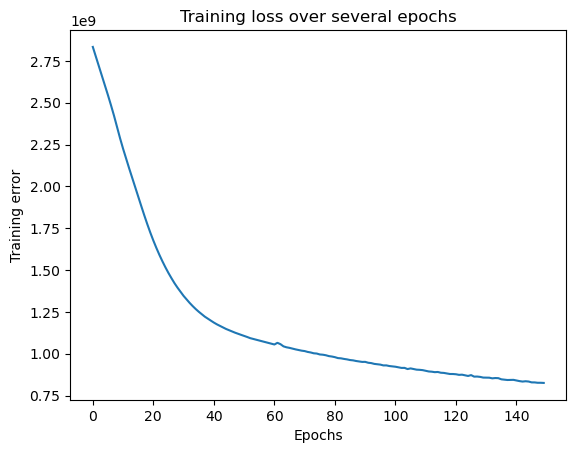

In [9]:
plt.plot(range(0, epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.title('Training loss over several epochs')
plt.show()

In [10]:
layer_size = 3096
model = nn.Sequential(
    nn.Linear(539, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.ReLU(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.ReLU(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.ReLU(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.ReLU(),
    nn.Linear(layer_size, 1)
)

In [11]:
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=539, out_features=3096, bias=True)
  (1): BatchNorm1d(3096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=3096, out_features=3096, bias=True)
  (4): BatchNorm1d(3096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=3096, out_features=3096, bias=True)
  (7): BatchNorm1d(3096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=3096, out_features=3096, bias=True)
  (10): BatchNorm1d(3096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=3096, out_features=1, bias=True)
)


In [12]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00000001)

In [13]:
losses = []

epochs = 125
for epoch in tqdm(range(epochs)):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
#    print(i, data)
    params, trip_time = data[0].to(device), data[1].to(device)
    trip_time = trip_time.float()
#    params, trip_time = params.float(), trip_time.float()
    trip_time = trip_time.reshape((trip_time.shape[0], 1))
    '''
    print(params)
    print(params.shape)
    print(trip_time)
    print(trip_time.shape)
    '''

    optimizer.zero_grad()
    params = params.to(torch.float)
    outputs = model(params)
#    print(outputs)
    loss = loss_fn(outputs, trip_time)
    running_loss += loss.item()
    loss.backward()
    model.float()
    optimizer.step()

#    if i % 2000 == 1999:    # print every 2000 mini-batches
#       print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
  print(f'[{epoch + 1}] loss: {running_loss / i:.13f}')
  losses.append(running_loss)

PATH = './jun7_9am.pth'
torch.save(model.state_dict(), PATH)

print("======= DONE =======")

  1%|          | 1/150 [02:01<5:02:43, 121.91s/it]

[1] loss: 989059.8569800070254


  1%|▏         | 2/150 [04:03<5:00:39, 121.89s/it]

[2] loss: 960442.8801078569377


  2%|▏         | 3/150 [06:05<4:58:37, 121.89s/it]

[3] loss: 932433.5512758680852


  3%|▎         | 4/150 [08:07<4:56:38, 121.91s/it]

[4] loss: 904866.5800267449813


  3%|▎         | 5/150 [10:09<4:54:35, 121.90s/it]

[5] loss: 877312.2920685724821


  4%|▍         | 6/150 [12:11<4:52:35, 121.91s/it]

[6] loss: 849755.3124890389154


  5%|▍         | 7/150 [14:13<4:50:34, 121.92s/it]

[7] loss: 821652.7118006839883


  5%|▌         | 8/150 [16:15<4:48:31, 121.91s/it]

[8] loss: 792277.6937039635377


  6%|▌         | 9/150 [18:17<4:46:29, 121.91s/it]

[9] loss: 762591.3925705893198


  7%|▋         | 10/150 [20:18<4:44:23, 121.88s/it]

[10] loss: 736331.5142165030120


  7%|▋         | 11/150 [22:20<4:42:25, 121.91s/it]

[11] loss: 712016.8740573483519


  8%|▊         | 12/150 [24:22<4:40:23, 121.91s/it]

[12] loss: 688643.0988578569377


  9%|▊         | 13/150 [26:24<4:38:24, 121.93s/it]

[13] loss: 666380.0573373377556


  9%|▉         | 14/150 [28:26<4:36:19, 121.91s/it]

[14] loss: 644807.9622500876430


 10%|█         | 15/150 [30:27<4:33:18, 121.47s/it]

[15] loss: 623616.8620604611933


 11%|█         | 16/150 [32:27<4:30:50, 121.27s/it]

[16] loss: 602893.1860366977053


 11%|█▏        | 17/150 [34:28<4:28:30, 121.13s/it]

[17] loss: 582905.0431317958282


 12%|█▏        | 18/150 [36:29<4:26:18, 121.05s/it]

[18] loss: 564074.9181591984816


 13%|█▎        | 19/150 [38:30<4:24:11, 121.01s/it]

[19] loss: 546865.4112098824698


 13%|█▎        | 20/150 [40:31<4:22:05, 120.96s/it]

[20] loss: 531022.3129494037712


 14%|█▍        | 21/150 [42:32<4:20:00, 120.93s/it]

[21] loss: 516336.8948230883689


 15%|█▍        | 22/150 [44:33<4:18:00, 120.94s/it]

[22] loss: 503784.4926067607594


 15%|█▌        | 23/150 [46:34<4:15:57, 120.92s/it]

[23] loss: 491720.7492930112057


 16%|█▌        | 24/150 [48:34<4:13:53, 120.90s/it]

[24] loss: 481145.0372237811098


 17%|█▋        | 25/150 [50:35<4:11:54, 120.91s/it]

[25] loss: 471796.4917189144180


 17%|█▋        | 26/150 [52:37<4:10:27, 121.19s/it]

[26] loss: 462869.0412629340426


 18%|█▊        | 27/150 [54:39<4:08:52, 121.41s/it]

[27] loss: 454661.9910064450814


 19%|█▊        | 28/150 [56:41<4:07:08, 121.55s/it]

[28] loss: 447546.8337096633040


 19%|█▉        | 29/150 [58:43<4:05:20, 121.66s/it]

[29] loss: 440794.7719002104714


 20%|██        | 30/150 [1:00:45<4:03:25, 121.71s/it]

[30] loss: 434642.7431931778556


 21%|██        | 31/150 [1:02:47<4:01:32, 121.78s/it]

[31] loss: 429697.0225469133584


 21%|██▏       | 32/150 [1:04:49<3:59:35, 121.83s/it]

[32] loss: 424127.4192772273091


 22%|██▏       | 33/150 [1:06:51<3:57:37, 121.86s/it]

[33] loss: 419365.4659439670504


 23%|██▎       | 34/150 [1:08:52<3:55:37, 121.87s/it]

[34] loss: 415456.4681306997663


 23%|██▎       | 35/150 [1:10:54<3:53:35, 121.87s/it]

[35] loss: 411098.9386070676846


 24%|██▍       | 36/150 [1:12:56<3:51:34, 121.88s/it]

[36] loss: 407530.3863775868085


 25%|██▍       | 37/150 [1:14:58<3:49:34, 121.89s/it]

[37] loss: 403838.0156195194577


 25%|██▌       | 38/150 [1:17:00<3:47:37, 121.94s/it]

[38] loss: 400711.5352370878682


 26%|██▌       | 39/150 [1:19:02<3:45:32, 121.92s/it]

[39] loss: 398074.0532981848228


 27%|██▋       | 40/150 [1:21:04<3:43:29, 121.91s/it]

[40] loss: 395499.3814752498874


 27%|██▋       | 41/150 [1:23:06<3:41:27, 121.91s/it]

[41] loss: 392746.6266277183313


 28%|██▊       | 42/150 [1:25:08<3:39:26, 121.91s/it]

[42] loss: 389799.1446038670838


 29%|██▊       | 43/150 [1:27:10<3:37:24, 121.91s/it]

[43] loss: 387640.9868686425616


 29%|██▉       | 44/150 [1:29:12<3:35:19, 121.88s/it]

[44] loss: 385216.5049461811432


 30%|███       | 45/150 [1:31:13<3:33:19, 121.90s/it]

[45] loss: 383487.2019357242971


 31%|███       | 46/150 [1:33:15<3:31:17, 121.90s/it]

[46] loss: 381307.7387402446475


 31%|███▏      | 47/150 [1:35:17<3:29:17, 121.91s/it]

[47] loss: 379691.7125076727243


 32%|███▏      | 48/150 [1:37:19<3:27:15, 121.91s/it]

[48] loss: 377570.1116877850145


 33%|███▎      | 49/150 [1:39:21<3:25:13, 121.92s/it]

[49] loss: 375408.7482982944348


 33%|███▎      | 50/150 [1:41:23<3:23:11, 121.92s/it]

[50] loss: 374039.8360388898873


 34%|███▍      | 51/150 [1:43:25<3:21:11, 121.94s/it]

[51] loss: 371945.2706670904881


 35%|███▍      | 52/150 [1:45:27<3:19:08, 121.92s/it]

[52] loss: 370466.1351033628453


 35%|███▌      | 53/150 [1:47:29<3:17:07, 121.93s/it]

[53] loss: 368076.5708030076930


 36%|███▌      | 54/150 [1:49:31<3:15:05, 121.94s/it]

[54] loss: 366746.1685483164038


 37%|███▋      | 55/150 [1:51:33<3:13:03, 121.93s/it]

[55] loss: 365116.2871443133918


 37%|███▋      | 56/150 [1:53:35<3:11:01, 121.93s/it]

[56] loss: 363644.1600206068251


 38%|███▊      | 57/150 [1:55:37<3:09:01, 121.95s/it]

[57] loss: 361410.6099120922736


 39%|███▊      | 58/150 [1:57:39<3:06:56, 121.92s/it]

[58] loss: 360231.7993302788236


 39%|███▉      | 59/150 [1:59:40<3:04:55, 121.93s/it]

[59] loss: 359327.0265394817689


 40%|████      | 60/150 [2:01:42<3:02:53, 121.92s/it]

[60] loss: 358203.9697036127909


 41%|████      | 61/150 [2:03:44<3:00:51, 121.92s/it]

[61] loss: 356140.6940601981478


 41%|████▏     | 62/150 [2:05:46<2:58:49, 121.92s/it]

[62] loss: 355262.3369212556863


 42%|████▏     | 63/150 [2:07:48<2:56:48, 121.93s/it]

[63] loss: 353391.9291668493534


 43%|████▎     | 64/150 [2:09:50<2:54:45, 121.92s/it]

[64] loss: 352068.9980516704381


 43%|████▎     | 65/150 [2:11:52<2:52:43, 121.93s/it]

[65] loss: 350309.6279868905549


 44%|████▍     | 66/150 [2:13:54<2:50:41, 121.93s/it]

[66] loss: 348332.9783518940676


 45%|████▍     | 67/150 [2:15:56<2:48:39, 121.92s/it]

[67] loss: 347863.3917211066582


 45%|████▌     | 68/150 [2:17:58<2:46:37, 121.92s/it]

[68] loss: 346473.5894313398749


 46%|████▌     | 69/150 [2:20:00<2:44:37, 121.94s/it]

[69] loss: 345120.1792654989404


 47%|████▋     | 70/150 [2:22:02<2:42:34, 121.93s/it]

[70] loss: 344088.3729228779557


 47%|████▋     | 71/150 [2:24:04<2:40:32, 121.93s/it]

[71] loss: 342531.8572814363288


 48%|████▊     | 72/150 [2:26:05<2:38:20, 121.80s/it]

[72] loss: 341297.7056323438883


 49%|████▊     | 73/150 [2:28:06<2:35:47, 121.40s/it]

[73] loss: 339903.8637813486275


 49%|████▉     | 74/150 [2:30:07<2:33:37, 121.29s/it]

[74] loss: 338533.2936661478598


 50%|█████     | 75/150 [2:32:08<2:31:49, 121.46s/it]

[75] loss: 337701.4961033409345


 51%|█████     | 76/150 [2:34:10<2:29:59, 121.61s/it]

[76] loss: 336585.2807348298957


 51%|█████▏    | 77/150 [2:36:12<2:28:02, 121.68s/it]

[77] loss: 334823.6935505085858


 52%|█████▏    | 78/150 [2:38:14<2:26:05, 121.74s/it]

[78] loss: 334406.5557479831623


 53%|█████▎    | 79/150 [2:40:16<2:24:07, 121.80s/it]

[79] loss: 332690.8809189758031


 53%|█████▎    | 80/150 [2:42:18<2:22:08, 121.84s/it]

[80] loss: 331528.8939133199165


 54%|█████▍    | 81/150 [2:44:20<2:20:08, 121.87s/it]

[81] loss: 329999.8726707734168


 55%|█████▍    | 82/150 [2:46:22<2:18:08, 121.88s/it]

[82] loss: 329708.0676955454401


 55%|█████▌    | 83/150 [2:48:24<2:16:07, 121.90s/it]

[83] loss: 328038.1342319580726


 56%|█████▌    | 84/150 [2:50:26<2:14:05, 121.90s/it]

[84] loss: 327141.9393935241969


 57%|█████▋    | 85/150 [2:52:28<2:12:05, 121.92s/it]

[85] loss: 326387.8042956418940


 57%|█████▋    | 86/150 [2:54:30<2:10:03, 121.92s/it]

[86] loss: 325551.7218985662912


 58%|█████▊    | 87/150 [2:56:32<2:08:01, 121.93s/it]

[87] loss: 324792.3568649158115


 59%|█████▊    | 88/150 [2:58:33<2:05:51, 121.80s/it]

[88] loss: 322619.8786801780225


 59%|█████▉    | 89/150 [3:00:34<2:03:40, 121.65s/it]

[89] loss: 322436.6232489696704


 60%|██████    | 90/150 [3:02:36<2:01:44, 121.74s/it]

[90] loss: 321743.4788204796496


 61%|██████    | 91/150 [3:04:38<1:59:45, 121.79s/it]

[91] loss: 319736.1685291345348


 61%|██████▏   | 92/150 [3:06:40<1:57:46, 121.84s/it]

[92] loss: 319178.6966113863746


 62%|██████▏   | 93/150 [3:08:42<1:55:45, 121.86s/it]

[93] loss: 317899.4258456462412


 63%|██████▎   | 94/150 [3:10:44<1:53:45, 121.89s/it]

[94] loss: 317568.2201804191573


 63%|██████▎   | 95/150 [3:12:46<1:51:44, 121.90s/it]

[95] loss: 316831.2069915161119


 64%|██████▍   | 96/150 [3:14:48<1:49:42, 121.90s/it]

[96] loss: 315758.2900736583397


 65%|██████▍   | 97/150 [3:16:50<1:47:41, 121.91s/it]

[97] loss: 315859.1186672439217


 65%|██████▌   | 98/150 [3:18:52<1:45:39, 121.92s/it]

[98] loss: 314673.7067065284355


 66%|██████▌   | 99/150 [3:20:54<1:43:36, 121.90s/it]

[99] loss: 314088.7947677350021


 67%|██████▋   | 100/150 [3:22:56<1:41:35, 121.92s/it]

[100] loss: 313429.6789421474678


 67%|██████▋   | 101/150 [3:24:57<1:39:34, 121.93s/it]

[101] loss: 312105.5163922746433


 68%|██████▊   | 102/150 [3:26:59<1:37:32, 121.92s/it]

[102] loss: 310408.0586170422612


 69%|██████▊   | 103/150 [3:29:01<1:35:30, 121.93s/it]

[103] loss: 309365.6118659023196


 69%|██████▉   | 104/150 [3:31:03<1:33:26, 121.89s/it]

[104] loss: 309672.5949420159450


 70%|███████   | 105/150 [3:33:05<1:31:25, 121.91s/it]

[105] loss: 308285.0730171431205


 71%|███████   | 106/150 [3:35:07<1:29:23, 121.90s/it]

[106] loss: 307522.5598035776638


 71%|███████▏  | 107/150 [3:37:09<1:27:21, 121.90s/it]

[107] loss: 307168.6766266222112


 72%|███████▏  | 108/150 [3:39:11<1:25:21, 121.93s/it]

[108] loss: 305416.1065251227701


 73%|███████▎  | 109/150 [3:41:13<1:23:18, 121.90s/it]

[109] loss: 305523.2993001359282


 73%|███████▎  | 110/150 [3:43:15<1:21:16, 121.92s/it]

[110] loss: 305691.6957838258240


 74%|███████▍  | 111/150 [3:45:17<1:19:14, 121.92s/it]

[111] loss: 304189.2887994344346


 75%|███████▍  | 112/150 [3:47:19<1:17:12, 121.92s/it]

[112] loss: 303781.8671655778890


 75%|███████▌  | 113/150 [3:49:20<1:15:10, 121.91s/it]

[113] loss: 302694.3401027051732


 76%|███████▌  | 114/150 [3:51:22<1:13:08, 121.91s/it]

[114] loss: 301388.9250509689446


 77%|███████▋  | 115/150 [3:53:24<1:11:07, 121.92s/it]

[115] loss: 300317.2163467862410


 77%|███████▋  | 116/150 [3:55:26<1:09:05, 121.92s/it]

[116] loss: 300743.2800196203170


 78%|███████▊  | 117/150 [3:57:28<1:07:03, 121.94s/it]

[117] loss: 299219.3100803446141


 79%|███████▊  | 118/150 [3:59:30<1:05:01, 121.91s/it]

[118] loss: 297916.0603598518064


 79%|███████▉  | 119/150 [4:01:32<1:02:59, 121.93s/it]

[119] loss: 296873.0623520255904


 80%|████████  | 120/150 [4:03:34<1:00:58, 121.93s/it]

[120] loss: 297238.6072101893951


 81%|████████  | 121/150 [4:05:36<58:56, 121.94s/it]  

[121] loss: 296046.1434008900542


 81%|████████▏ | 122/150 [4:07:38<56:54, 121.95s/it]

[122] loss: 295447.6808932172717


 82%|████████▏ | 123/150 [4:09:40<54:52, 121.94s/it]

[123] loss: 295025.3119218037464


 83%|████████▎ | 124/150 [4:11:42<52:50, 121.95s/it]

[124] loss: 294262.9426791038131


 83%|████████▎ | 125/150 [4:13:44<50:48, 121.93s/it]

[125] loss: 293562.7593251271755


 84%|████████▍ | 126/150 [4:15:46<48:46, 121.95s/it]

[126] loss: 292299.4516041520401


 85%|████████▍ | 127/150 [4:17:48<46:44, 121.95s/it]

[127] loss: 293465.9795658321818


 85%|████████▌ | 128/150 [4:19:50<44:43, 121.96s/it]

[128] loss: 291529.0759766310221


 86%|████████▌ | 129/150 [4:21:51<42:40, 121.95s/it]

[129] loss: 291636.5087606322486


 87%|████████▋ | 130/150 [4:23:55<40:50, 122.51s/it]

[130] loss: 291273.9410897492198


 87%|████████▋ | 131/150 [4:25:59<38:52, 122.77s/it]

[131] loss: 289055.5549231629120


 88%|████████▊ | 132/150 [4:28:02<36:53, 122.98s/it]

[132] loss: 288617.9840078043053


 89%|████████▊ | 133/150 [4:30:05<34:48, 122.83s/it]

[133] loss: 289328.6512161302962


 89%|████████▉ | 134/150 [4:32:07<32:43, 122.70s/it]

[134] loss: 288556.8666230050731


 90%|█████████ | 135/150 [4:34:11<30:44, 122.95s/it]

[135] loss: 288396.6117672527325


 91%|█████████ | 136/150 [4:36:12<28:37, 122.64s/it]

[136] loss: 286469.5559562434210


 91%|█████████▏| 137/150 [4:38:14<26:31, 122.44s/it]

[137] loss: 286951.5503222553525


 92%|█████████▏| 138/150 [4:40:16<24:27, 122.28s/it]

[138] loss: 286435.3114340362954


 93%|█████████▎| 139/150 [4:42:18<22:23, 122.18s/it]

[139] loss: 284972.7134393634042


 93%|█████████▎| 140/150 [4:44:20<20:21, 122.11s/it]

[140] loss: 285149.2023029200500


 94%|█████████▍| 141/150 [4:46:22<18:18, 122.05s/it]

[141] loss: 283860.0200477902545


 95%|█████████▍| 142/150 [4:48:24<16:16, 122.01s/it]

[142] loss: 284115.3778690590989


 95%|█████████▌| 143/150 [4:50:26<14:13, 121.96s/it]

[143] loss: 282808.9517713083187


 96%|█████████▌| 144/150 [4:52:28<12:11, 121.95s/it]

[144] loss: 283557.1183548535337


 97%|█████████▋| 145/150 [4:54:30<10:09, 121.93s/it]

[145] loss: 281381.7017795291031


 97%|█████████▋| 146/150 [4:56:32<08:07, 121.93s/it]

[146] loss: 281170.8764715231373


 98%|█████████▊| 147/150 [4:58:34<06:05, 121.93s/it]

[147] loss: 280998.0222783672507


 99%|█████████▊| 148/150 [5:00:36<04:03, 121.93s/it]

[148] loss: 281057.0321597685106


 99%|█████████▉| 149/150 [5:02:37<02:01, 121.95s/it]

[149] loss: 281057.8184847421944


100%|██████████| 150/150 [5:04:39<00:00, 121.87s/it]

[150] loss: 279025.6925914153107
======= DONE =======


ValueError: x and y must have same first dimension, but have shapes (150,) and (427800,)

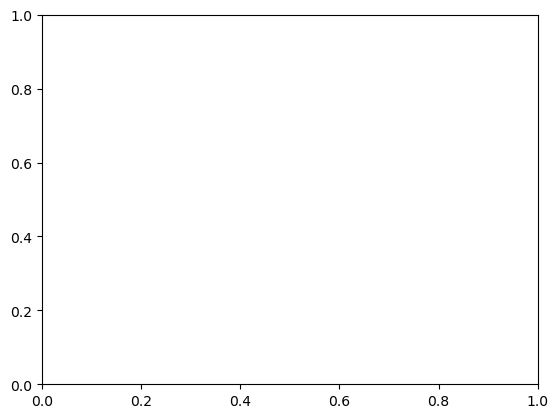

In [14]:
plt.plot(range(0, epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.title('Training loss over several epochs')
plt.show()